# Classificating danger tweets

### Jacopo Magliani mat:2040912

## Loading dataset

In [1]:
import numpy as np
import pandas as pd 
#pd.set_option('display.max_colwidth', None)
#pip install https://github.com/elyase/geotext/archive/master.zip    
from geotext import GeoText
#conda install -c conda-forge/label/gcc7 pycountry
import pycountry
import re
import nltk
from nltk.corpus import stopwords #['i', 'me', 'my', 'myself', 'we', 'the', 'a' , 'an' ,...
from collections import Counter

data_url = 'https://www.math.unipd.it/~dasan/disaster/'
train_csv = pd.read_csv(data_url + 'train.csv', sep=",") 
test_csv = pd.read_csv(data_url + 'test.csv', sep=",")
train_csv.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [2]:
train_csv.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


## Preprocessing

In [3]:
col_list = list(train_csv.columns)
for i in col_list:
    print(i + " NaN values: " + str(sum(train_csv[str(i)].isna())))

id NaN values: 0
keyword NaN values: 61
location NaN values: 2533
text NaN values: 0
target NaN values: 0


In [4]:
print("Rows with NaN values in 'Keyword' are {:2.2}% of the total dataset"
      .format(sum(train_csv['keyword'].isna())/train_csv.shape[0]*100))

Rows with NaN values in 'Keyword' are 0.8% of the total dataset


In [5]:
train_csv = train_csv[~train_csv['keyword'].isna()]

In [6]:
#Function to erase some given words and the common english words from every string of a column.
#Erase also the special characters and numbers
#'3 fires in #NewYork!' -> ' fires in NewYork ' -> 'fires NewYork'
def clear_string(df,col):
    erase_words = ('http','www','url')
    comwords = set(stopwords.words('english'))
    df[col] = df[col].apply(lambda x:str(x))
    df[col] = df[col].apply(lambda x:x.split())
    df[col] = df[col].apply(lambda x:[i for i in x if not i.startswith(erase_words)])
    df[col] = df[col].apply(lambda x:' '.join(x))
    df[col] = df[col].apply(lambda x:re.sub('\W+',' ',str(x)))
    df[col] = df[col].apply(lambda x:re.sub('[0-9]','',x))
    df[col] = df[col].apply(lambda x:x.split())
    df[col] = df[col].apply(lambda x:[i for i in x if (i not in comwords)])
    df[col] = df[col].apply(lambda x:' '.join(x))
    
#Separate each word with #
#Make sure the string starts with #+capital letter and finishes with #
#Separating each word with # and adding # in front and in the tail is necessary when finding the ISO code to avoid collisions
#'fires KY' -> '#Fires#KY#'
def prepare_text(df,col):
    df[col+'_modded']= df[col]
    clear_string(df,col+'_modded')
    df[col+'_modded'] = df[col+'_modded'].apply(lambda x: ' ' + str(x) + ' ')
    df[col+'_modded'] = df[col+'_modded'].apply(lambda x:x.upper()[0]+x[1:])
    df[col+'_modded'] = df[col+'_modded'].apply(lambda x: x.replace(' ','#'))
#Capitalize every first letter of each word
#'fire italy' -> 'Fire Italy'
#Divide consecutive uppercase words
#'NorthCarolina' -> 'North Carolina'
def prepare_text2(df,col):
    df[col+'_modded_2']= df[col]
    clear_string(df,col+'_modded_2')
    df[col+'_modded_2'] = df[col+'_modded_2'].apply(lambda x:x.split())
    df[col+'_modded_2'] = df[col+'_modded_2'].apply(lambda x:[i.upper()[0]+i[1:] for i in x])
    df[col+'_modded_2'] = df[col+'_modded_2'].apply(lambda x:' '.join(x))
    df[col+'_modded_2'] = df[col+'_modded_2'].apply(lambda x:re.findall('[A-Z][^A-Z]*',x))
    df[col+'_modded_2'] = df[col+'_modded_2'].apply(lambda x:' '.join(x))
    df[col+'_modded_2'] = df[col+'_modded_2'].apply(lambda x: x.replace('  ',' '))

In [7]:
#Get the ISO code of the mentioned location by GeoText
def get_loc(df,col,col_final):
    df['loc_2'] = df[col]
    df['loc_2'] = df['loc_2'].apply(lambda x:GeoText(x).country_mentions if (not pd.isna(x)) else [])
    df['loc_2'] = df['loc_2'].apply(lambda x:np.nan if (len(x)==0) else x.popitem()[0])
    df[col_final].fillna(df['loc_2'],inplace=True)
    df.drop(['loc_2'],axis=1,inplace=True)
#Find the ISO code in the text
#'fire IT' -> 'IT'
def get_iso(df,col,col_final):
    country_set = set()
    for i in list(pycountry.countries): #[111]->Country(alpha_2='IT', alpha_3='ITA', name='Italy', numeric='380', official_name='Italian Republic')
        country_set.add(i.alpha_2)
    df['loc_2']=df[col]
    df['loc_2'] = df['loc_2'].apply(lambda x:x if (not pd.isna(x)) else '')
    df['loc_2'] = df['loc_2'].apply(lambda x: list(country_set.intersection(x.split('#')))[0] 
                                    if len(list(country_set.intersection(x.split('#'))))>0 else np.nan)
    df[col_final].fillna(df['loc_2'],inplace=True)
    df.drop(['loc_2'],axis=1,inplace=True)
    
#Get the ISO code of the mentioned location for the us states
#GeoText and pycountry can't identify a single state like California/CA
def get_loc_usa(df,col,col_final):
    us_states_set = set()
    us_states_set.update(["Alabama","Alaska","Arizona","Arkansas","California","Colorado","Connecticut","Delaware","Florida",
                      "Georgia","Hawaii","Idaho","Illinois","Indiana","Iowa","Kansas","Kentucky","Louisiana","Maine",
                      "Maryland","Massachusetts","Michigan","Minnesota","Mississippi","Missouri","Montana","Nebraska",
                      "Nevada","New Hampshire","New Jersey","New Mexico","New York","North Carolina","North Dakota",
                      "Ohio","Oklahoma","Oregon","Pennsylvania","Rhode Island","South Carolina","South Dakota",
                      "Tennessee","Texas","Utah","Vermont","Virginia","Washington","West Virginia","Wisconsin",
                      "Wyoming",'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA','HI', 'IA', 'ID',
                      'IL', 'IN', 'KS','KY', 'LA', 'MA', 'MD', 'ME','MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE',
                      'NH', 'NJ', 'NM','NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX','UT', 
                      'VA', 'VT', 'WA', 'WI', 'WV', 'WY'])
    df['loc_2'] = df[col]
    df['loc_2'] = df['loc_2'].apply(lambda x:x if (not pd.isna(x)) else [])
    df['loc_2'] = df['loc_2'].apply(lambda x:'US' if any('#'+state+'#' in x for state in us_states_set) else np.nan)
    df[col_final].fillna(df['loc_2'],inplace=True)
    df.drop(['loc_2'],axis=1,inplace=True)

In [8]:
#Substitute the strings Nan and nan with np.nan
#This is necessary mostly because GeoText identify Nan as a city of Thailand and would assign 'TH'
def clear_nan(df,col):
    df[col]=df[col].apply(lambda x:x if (x!='Nan') & (x!='nan') else np.nan)

In [9]:
train_csv['loc']=np.nan
prepare_text(train_csv,'text'),prepare_text2(train_csv,'text')
prepare_text(train_csv,'location'),prepare_text2(train_csv,'location')

clear_nan(train_csv,'text_modded'),clear_nan(train_csv,'text_modded_2')
clear_nan(train_csv,'location_modded'),clear_nan(train_csv,'location_modded_2')

#First identify american locations to avoid errors
#'New Hampshire' -> get_loc_usa() -> 'US' correct
#'New Hampshire' -> get_loc() -> 'UK' error
get_loc_usa(train_csv,'text_modded_2','loc'),get_loc_usa(train_csv,'text_modded','loc')
get_loc_usa(train_csv,'location_modded','loc'),get_loc_usa(train_csv,'location_modded_2','loc')

get_loc(train_csv,'text_modded_2','loc'),get_loc(train_csv,'text_modded','loc')
get_loc(train_csv,'location_modded','loc'),get_loc(train_csv,'location_modded_2','loc')

get_iso(train_csv,'text_modded','loc'),get_iso(train_csv,'text_modded_2','loc')
get_iso(train_csv,'location_modded','loc'),get_iso(train_csv,'location_modded_2','loc')

(None, None)

In [10]:
#The feature location isn't always associated to the location of the topic of the tweet
train_csv[(train_csv['id']== 710) | (train_csv['id']== 7918)]

,id,keyword,location,text,target,loc,text_modded,text_modded_2,location_modded,location_modded_2
490,710,attacked,AKRON OHIO USA,Christian Attacked by Muslims at the Temple Mo...,1,IL,#Christian#Attacked#Muslims#Temple#Mount#Wavin...,Christian Attacked Muslims Temple Mount Waving...,#AKRON#OHIO#USA#,A K R O N O H I O U S A
5551,7918,rainstorm,United States of America,'Three #people were #killed when a severe #rai...,1,IT,#Three#people#killed#severe#rainstorm#Italian#...,Three People Killed Severe Rainstorm Italian A...,#United#States#America#,United States America


In [11]:
#Generally, if the location wasn't retrieved it is because it wasn't possibile recovering it from location or text
np.random.seed(55)
train_csv[(~train_csv['location'].isna()) & (train_csv['loc'].isna())].sample(5)

,id,keyword,location,text,target,loc,text_modded,text_modded_2,location_modded,location_modded_2
3035,4356,earthquake,One World,Some of the aftershocks can be just as big as ...,1,NaN,#Some#aftershocks#big#initial#earthquake#,Some Aftershocks Big Initial Earthquake,#One#World#,One World
4621,6569,injury,mnl,New level of tita-dom: bowling injury. http://...,0,NaN,#New#level#tita#dom#bowling#injury#,New Level Tita Dom Bowling Injury,#mnl#,Mnl
519,751,avalanche,guaravitas,we'll crash down like an avalanche,0,NaN,#crash#like#avalanche#,Crash Like Avalanche,#guaravitas#,Guaravitas
1207,1739,buildings%20burning,Ziam af,Messi: has tattoos so he can't donate blood\nR...,1,NaN,#Messi#tattoos#donate#blood#Ronaldo#runs#burni...,Messi Tattoos Donate Blood Ronaldo Runs Burnin...,#Ziam#af#,Ziam Af
1567,2263,cliff%20fall,nyc,ok peace I hope I fall off a cliff along with ...,1,NaN,#ok#peace#I#hope#I#fall#cliff#along#dignity#,Ok Peace I Hope I Fall Cliff Along Dignity,#nyc#,Nyc


In [12]:
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
#Check if all characters in the text are uppercase
def all_caps(df,col):
    df['all_caps'] = df[col].apply(lambda x:1 if x.isupper() else 0)
#Check if the location was retrieved
def loc_presence(df):
    df['has_loc'] = df['loc'].apply(lambda x:0 if pd.isna(x) else 1)
#Check if the location is of the top n most popular countries
def get_top_countries(df,n_top):
    top_countries = Counter(df[df['target']==1]['loc']).most_common(n_top)
    top_countries2 = []
    for i in range(len(top_countries)):
        name = top_countries.pop()[0]
        top_countries2.append(name)
        df[name + '_country'] = df['loc'].apply(lambda x: 1 if x==name else 0)
        df['top_country'] = df['loc'].apply(lambda x: 1 if x in top_countries2 else 0)
#Get a list of stems/lemmas for every string of the given column
def stemm(text):
    set_stemm = []
    porter_stemmer  = PorterStemmer()
    tokenization = nltk.word_tokenize(text)
    for w in tokenization:
        set_stemm.append(porter_stemmer.stem(w))
    return set_stemm
def get_stemm(df,col):
    df['stemm_'+col] = df[col].apply(lambda x:x.lower().replace('#',' '))
    df['stemm_'+col] = df['stemm_'+col].apply(lambda x:stemm(x))
def lemm(text):
    set_lemm = []
    wordnet_lemmatizer = WordNetLemmatizer()
    tokenization = nltk.word_tokenize(text)
    for w in tokenization:
        set_lemm.append(wordnet_lemmatizer.lemmatize(w))
    return set_lemm   
def get_lemm(df,col):
    df['lemm_'+col] = df[col].apply(lambda x:x.lower().replace('#',' '))
    df['lemm_'+col] = df['lemm_'+col].apply(lambda x:lemm(x))

In [13]:
all_caps(train_csv,"text")
loc_presence(train_csv)
get_top_countries(train_csv,4)
get_stemm(train_csv,'text_modded')
get_lemm(train_csv,'text_modded')

In [14]:
#Split the two keywords in two features
def get_keywords(df):
    clear_string(df,'keyword')
    df['keyword_list'] = df['keyword'].apply(lambda x:x.split())
    df['keyword_1'] = df['keyword_list'].apply(lambda x:x[0])
    df['keyword_2'] = df['keyword_list'].apply(lambda x:x[1] if len(x)>1 else np.nan)
    df.drop(['keyword_list'],axis=1,inplace=True)

In [15]:
#Given a string and a list of dangerous words, return the first two words of the list found in the string
#string = 'Rome rain danger fire' 
#listaparole = [danger,...,fire,...rain,...]
#return (danger,fire)
def text_danger(x,listaparole):
    couple_keys = []
    for word in listaparole:
        if(word in x):
            couple_keys.append(word)
    return couple_keys[:2]
#Get a list of the n words more spreaded in tweets of danger, then get for every string of a column the two most
#dangerous words
def get_text_list(df,col,n):
    j = []
    j.extend(w for x in df[df.target==1][col] for w in x if len(w)>3)
    listaparole = [x[0] for x in Counter(j).most_common(n)]
    df[col+'_list'] = df[col].apply(lambda x:text_danger(x,listaparole))
    df[col+'_1'] = df[col+'_list'].apply(lambda x:x[0] if len(x)>0 else np.nan) 
    df[col+'_2'] = df[col+'_list'].apply(lambda x:x[1] if len(x)>1 else np.nan) 
    df.drop([col+'_list'],axis=1,inplace=True)

In [16]:
#Define the percentage of danger of a word = #times in danger/#times in total
def word_danger(df,cols,word):
    tot=0
    part=0
    for c in cols:
        tot += sum(df[c]==word)
        part += sum((df[c]==word) & (df['target']==1))
    if(tot==0):
        return 0
    else:
        return round(part/tot,2)
#Get the danger for every word of the columns
def keywords_danger(df,cols):
    for c in cols:
        df['danger_'+c] = df[c].apply(lambda x:word_danger(df,cols,x))

In [17]:
get_keywords(train_csv)
get_text_list(train_csv,'stemm_text_modded',50)
get_text_list(train_csv,'lemm_text_modded',50)

In [18]:
keywords_danger(train_csv,['keyword_1','keyword_2']),
keywords_danger(train_csv,['stemm_text_modded_1','stemm_text_modded_2'])
keywords_danger(train_csv,['lemm_text_modded_1','lemm_text_modded_2'])

In [19]:
train_csv.iloc[0]

id                                                                           48
keyword                                                                  ablaze
location                                                             Birmingham
text                          @bbcmtd Wholesale Markets ablaze http://t.co/l...
target                                                                        1
loc                                                                          GB
text_modded                                   #bbcmtd#Wholesale#Markets#ablaze#
text_modded_2                                   Bbcmtd Wholesale Markets Ablaze
location_modded                                                    #Birmingham#
location_modded_2                                                    Birmingham
all_caps                                                                      0
has_loc                                                                       1
CA_country                              

## Analysis

In [20]:
train = train_csv[['all_caps','has_loc','top_country','CA_country','IN_country','GB_country','US_country',
                   'danger_keyword_1','danger_keyword_2','danger_stemm_text_modded_1','danger_stemm_text_modded_2',
                   'danger_lemm_text_modded_1','danger_lemm_text_modded_2','target']]
train = train.rename(columns={"danger_stemm_text_modded_1": "danger_stem_1",
                      "danger_stemm_text_modded_2": "danger_stem_2",
                      "danger_lemm_text_modded_1": "danger_lem_1",
                      "danger_lemm_text_modded_2": "danger_lem_2"})

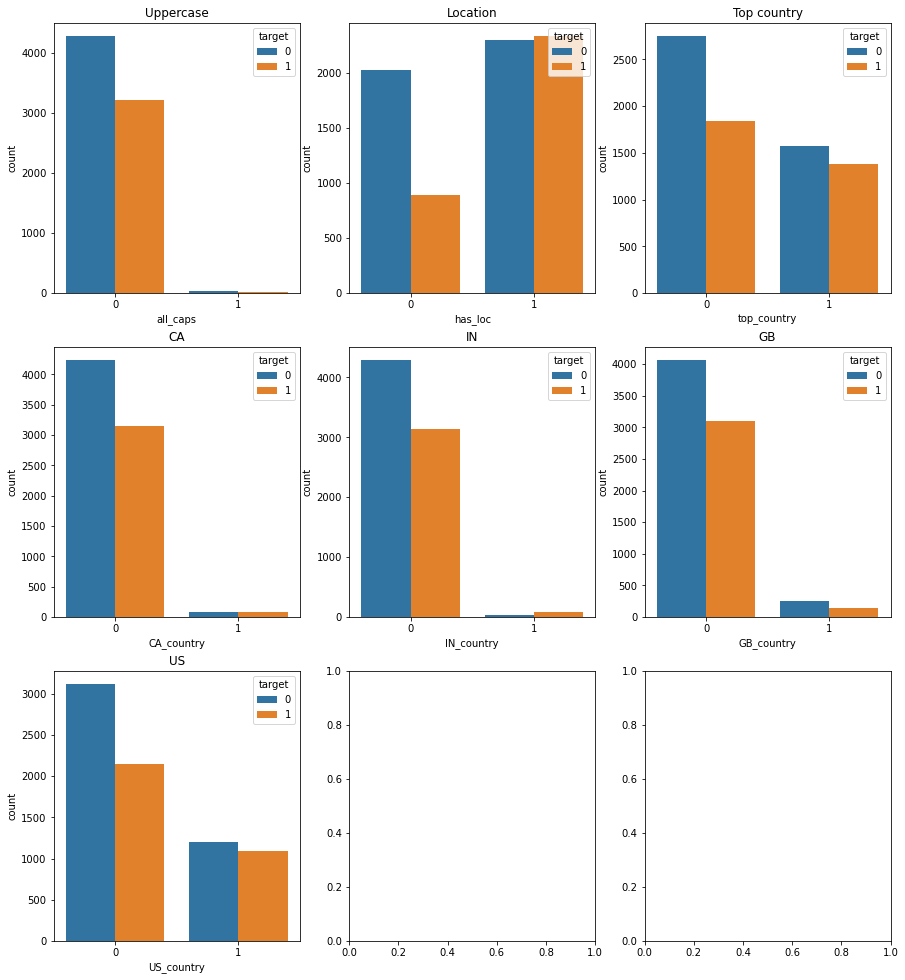

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax =plt.subplots(3,3,figsize=(15,10))
sns.countplot(x=train['all_caps'],hue=train['target'],ax=ax[0][0]).set_title("Uppercase")
sns.countplot(x=train['has_loc'],hue=train['target'],ax=ax[0][1]).set_title("Location")
sns.countplot(x=train['top_country'],hue=train['target'],ax=ax[0][2]).set_title("Top country")
sns.countplot(x=train['CA_country'],hue=train['target'],ax=ax[1][0]).set_title("CA")
sns.countplot(x=train['IN_country'],hue=train['target'],ax=ax[1][1]).set_title("IN")
sns.countplot(x=train['GB_country'],hue=train['target'],ax=ax[1][2]).set_title("GB")
sns.countplot(x=train['US_country'],hue=train['target'],ax=ax[2][0]).set_title("US")
fig.subplots_adjust(top=1.4)

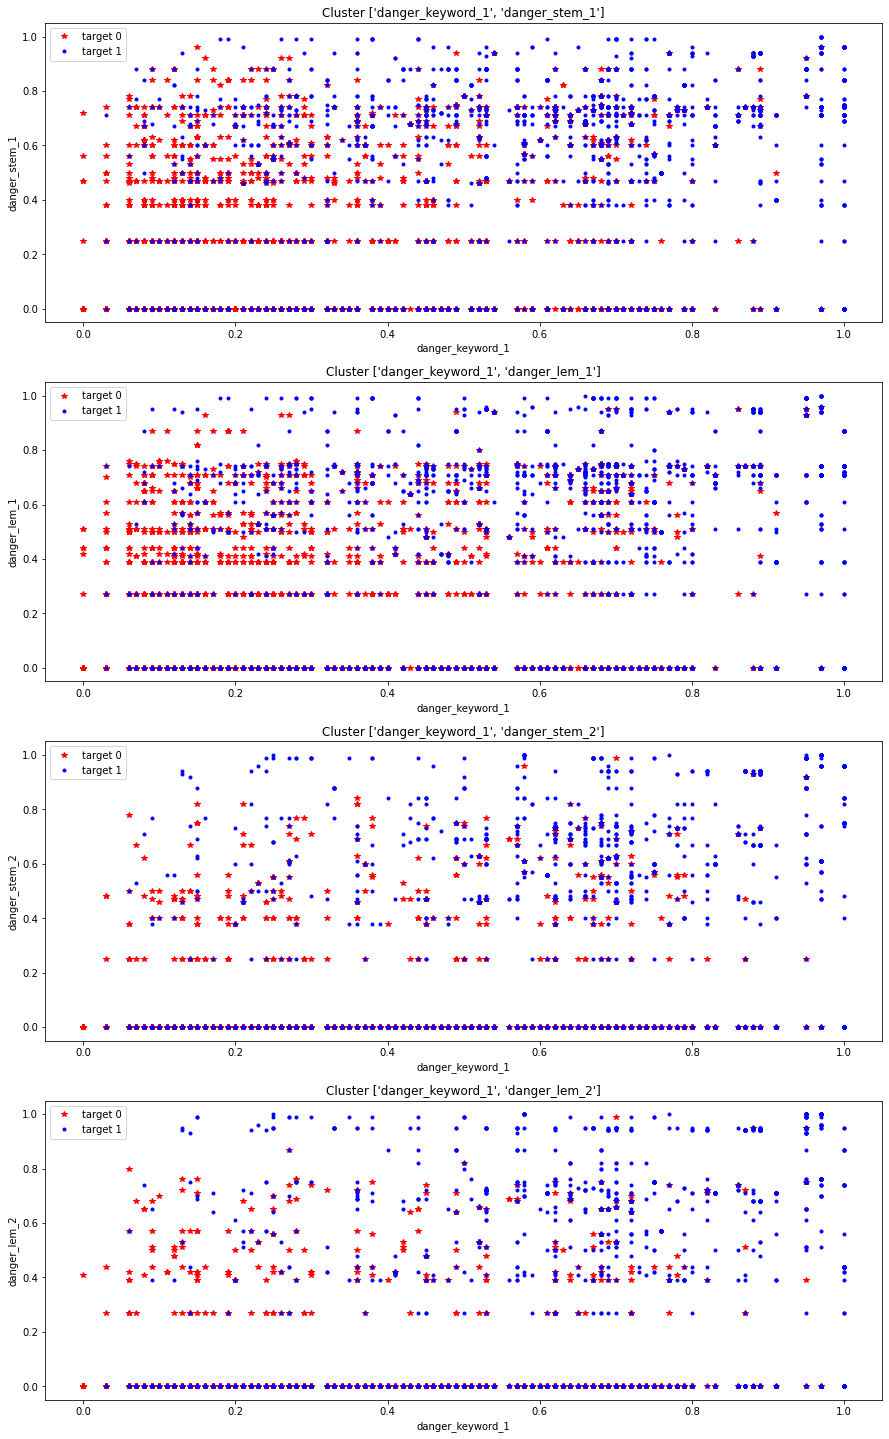

In [22]:
corr_features = [['danger_keyword_1','danger_stem_1'],['danger_keyword_1','danger_lem_1'],
                 ['danger_keyword_1','danger_stem_2'],['danger_keyword_1','danger_lem_2']]
fig,ax = plt.subplots(4, 1,figsize=(15,15))
for row,cf in zip(ax,corr_features):
        x0 = train[train['target']==0][cf[0]]
        y0 = train[train['target']==0][cf[1]]
        x1 = train[train['target']==1][cf[0]]
        y1 = train[train['target']==1][cf[1]]
        row.set_title("Cluster " + str(cf))
        row.set_xlabel(cf[0])
        row.set_ylabel(cf[1])
        row.plot(x0,y0,'r*',label="target 0")
        row.plot(x1,y1,'b.',label="target 1")
        row.legend()
fig.subplots_adjust(top=1.4)

## Machine Learning

In [23]:
X = train.iloc[:,:-1]
y = train.iloc[:,-1]

In [24]:
#Since the entropy of the target feature is high I decide to use accuracy score
#from sklearn.metrics import accuracy_score
print("Entropy: {}".format(-sum(y==1)/len(y)*np.log2(sum(y==1)/len(y))-sum(y==0)/len(y)*np.log2(sum(y==0)/len(y))))

Entropy: 0.9848090695365586


In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
#Train the model with the given parameters to identify the optimal parameters 
def gridmodel(model,para):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 123)
    gs = GridSearchCV(model(), para, cv=5,scoring="accuracy")
    gs.fit(X_train,y_train)
    return gs.best_params_
#Plot the confusion matrix of the model
from sklearn.metrics import confusion_matrix
def confmat(name_model,model):
    results = confusion_matrix(y_test, model.predict(X_test))
    names = ['TN','FP','FN','TP']
    counts = ['{0:0.0f}'.format(value) for value in results.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in results.flatten()/np.sum(results)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names, counts, percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize=(6,4))
    sns.heatmap(results/np.sum(results),annot=labels,fmt='')
    plt.title(name_model +" confusion matrix")
    plt.show()
#Plot the importance of the top 4 features of the model    
def featimp(name_model,model):
    features = pd.Series(model.feature_importances_, index=X.columns).nlargest(4)
    features.plot(kind='barh')
    plt.title(name_model + " top 4 features")
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.show()

#conda install mlxtend
from mlxtend.evaluate import bias_variance_decomp
def loss(model):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 123)
    loss, bias, var = bias_variance_decomp(model, X_train.values, y_train.values, X_test.values, y_test.values, 
                                      loss='0-1_loss', num_rounds=200, random_seed=123)
    print('Average expected loss: %.3f' % loss)
    print('Bias: %.3f' % bias)
    print('Variance: %.3f' % var)

Settings: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 10}
Train accuracy: 0.78
Validation accuracy: 0.74
Test accuracy: 0.76


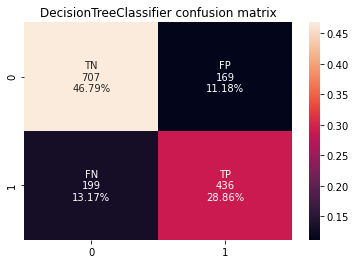

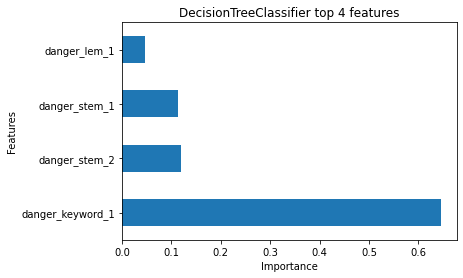

Average expected loss: 0.245
Bias: 0.234
Variance: 0.079


In [26]:
#CLASSIFICATION TREE
from sklearn.tree import DecisionTreeClassifier
tree_para = {'criterion':['gini','entropy'],
             'max_depth':range(1,11),
            'min_samples_split':range(2,11)}
tree_settings = gridmodel(DecisionTreeClassifier,tree_para)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size = 0.9, random_state = 123)
dtc = DecisionTreeClassifier(criterion = tree_settings.get("criterion"),
                       max_depth = tree_settings.get("max_depth"),
                       min_samples_split = tree_settings.get("min_samples_split")
                      )
dtc.fit(X_train,y_train)
print("Settings: {}".format(tree_settings))
train_acc = round(dtc.score(X_train, y_train),2)  
val_acc = round(dtc.score(X_val, y_val),2)       
test_acc = round(dtc.score(X_test, y_test),2)
print("Train accuracy: {}\nValidation accuracy: {}\nTest accuracy: {}".format(train_acc,val_acc,test_acc))
confmat("DecisionTreeClassifier",dtc)
featimp("DecisionTreeClassifier",dtc)
loss(dtc)

Settings: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 90}
Train accuracy: 0.82
Validation accuracy: 0.76
Test accuracy: 0.77


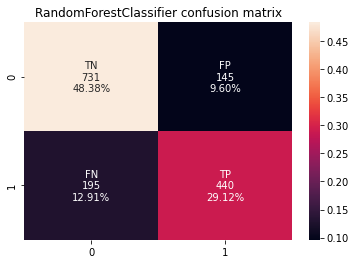

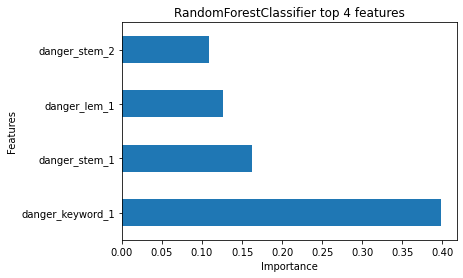

Average expected loss: 0.233
Bias: 0.222
Variance: 0.047


In [27]:
#RANDOM FOREST CLASSIFIER
from sklearn.ensemble import RandomForestClassifier
forest_para = {'criterion':['gini','entropy'],
             'n_estimators':range(10,101,10),
             'max_depth':range(3,11)}
forest_settings = gridmodel(RandomForestClassifier,forest_para)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size = 0.9, random_state = 123)
rfc = RandomForestClassifier(criterion = forest_settings.get("criterion"),
                       n_estimators = forest_settings.get("n_estimators"),
                       max_depth = forest_settings.get("max_depth")
                      )
rfc.fit(X_train,y_train)
print("Settings: {}".format(forest_settings))
train_acc = round(rfc.score(X_train, y_train),2)  
val_acc = round(rfc.score(X_val, y_val),2)       
test_acc = round(rfc.score(X_test, y_test),2)
print("Train accuracy: {}\nValidation accuracy: {}\nTest accuracy: {}".format(train_acc,val_acc,test_acc))
confmat("RandomForestClassifier",rfc)
featimp("RandomForestClassifier",rfc)
loss(rfc)

Settings: {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'uniform'}
Train accuracy: 0.79
Validation accuracy: 0.74
Test accuracy: 0.76


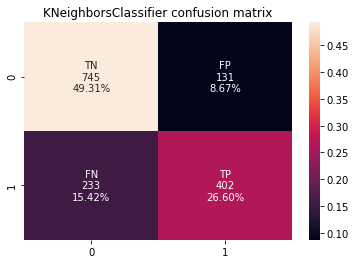

Average expected loss: 0.252
Bias: 0.234
Variance: 0.091


In [28]:
#KNN Classifier
from sklearn.neighbors import KNeighborsClassifier
knn_para = {'n_neighbors':range(3,11),
            'weights':['uniform','distance'],
            'metric':['euclidean','chebyshev','minkowski','manhattan'],
             }
knn_settings = gridmodel(KNeighborsClassifier,knn_para)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size = 0.9, random_state = 123)
knc = KNeighborsClassifier(metric = knn_settings.get("metric"),
                           weights = knn_settings.get("weights"),
                       n_neighbors = knn_settings.get("n_neighbors")
                      )
knc.fit(X_train,y_train)
print("Settings: {}".format(knn_settings))
train_acc = round(knc.score(X_train, y_train),2)  
val_acc = round(knc.score(X_val, y_val),2)       
test_acc = round(knc.score(X_test, y_test),2)
print("Train accuracy: {}\nValidation accuracy: {}\nTest accuracy: {}".format(train_acc,val_acc,test_acc))
confmat("KNeighborsClassifier",knc)
loss(knc)

Settings: {'activation': 'relu', 'hidden_layer_sizes': (20, 20), 'solver': 'adam'}
Train accuracy: 0.77
Validation accuracy: 0.75
Test accuracy: 0.76


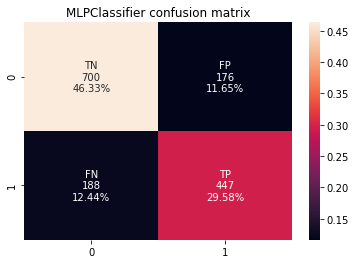

In [29]:
#MLP CLASSIFIER
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings("ignore")
mlp_para = {
            'activation':['logistic','relu'],
            'solver':['sgd','adam'],
            'hidden_layer_sizes': [(20,10),(20,20),(20,30)]
            }
mlp_settings = gridmodel(MLPClassifier,mlp_para)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size = 0.9, random_state = 123)
mlp = MLPClassifier(activation = mlp_settings.get("activation"),
                    solver = mlp_settings.get("solver"),
                    hidden_layer_sizes = mlp_settings.get("hidden_layer_sizes"),                   
                      )
mlp.fit(X_train,y_train)
print("Settings: {}".format(mlp_settings))
train_acc = round(mlp.score(X_train, y_train),2)  
val_acc = round(mlp.score(X_val, y_val),2)       
test_acc = round(mlp.score(X_test, y_test),2)
print("Train accuracy: {}\nValidation accuracy: {}\nTest accuracy: {}".format(train_acc,val_acc,test_acc))
confmat("MLPClassifier",mlp)

In [30]:
loss(mlp)

Average expected loss: 0.239
Bias: 0.234
Variance: 0.044


In [31]:
#TEST OF THE BEST MODEL 
final_train = train.loc[1+int(train.shape[0]/3):,:]
final_test = train.loc[:int(train.shape[0]/3),:]

In [32]:
X_final_train = final_train.iloc[:,:-1]
y_final_train = final_train.iloc[:,-1]
X_final_test = final_test.iloc[:,:-1]

In [33]:
rfc.fit(X_final_train,y_final_train)
final_test['target_predicted'] = rfc.predict(X_final_test)
sum(final_test['target'] == final_test['target_predicted'] )/final_test.shape[0]

0.7720144752714113

In [34]:
final_test

,all_caps,has_loc,top_country,CA_country,IN_country,GB_country,US_country,danger_keyword_1,danger_keyword_2,danger_stem_1,danger_stem_2,danger_lem_1,danger_lem_2,target,target_predicted
31,0,1,1,0,0,1,0,0.36,0.0,0.00,0.0,0.00,0.0,1,0
32,0,1,1,0,0,1,0,0.36,0.0,0.00,0.0,0.00,0.0,0,0
33,0,1,0,0,0,0,0,0.36,0.0,0.71,0.0,0.71,0.0,1,0
34,0,1,1,0,0,0,1,0.36,0.0,0.00,0.0,0.00,0.0,0,0
35,0,1,1,0,0,1,0,0.36,0.0,0.00,0.0,0.00,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2513,0,0,0,0,0,0,0,0.19,0.0,0.00,0.0,0.00,0.0,0,0
2514,0,1,0,0,0,0,0,0.19,0.0,0.00,0.0,0.00,0.0,0,0
2515,0,0,0,0,0,0,0,0.19,0.0,0.00,0.0,0.00,0.0,0,0
2516,0,1,1,0,0,0,1,0.19,0.0,0.00,0.0,0.00,0.0,1,0
